In [ ]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
module_path = os.path.abspath(
    os.path.join(
        "/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control"
    )
)
if module_path not in sys.path:
    sys.path.append(module_path)

from q_env_config_edu_example import (
    q_env_config as gate_q_env_config,
)
from quantumenvironment import QuantumEnvironment
from gymnasium.wrappers import RescaleAction, ClipAction

from ppo_while_not_met_baseline import make_train_ppo
from helper_functions import load_from_pickle

import logging

logging.basicConfig(
    level=logging.WARNING,
    format="%(asctime)s INFO %(message)s",  # hardcoded INFO level
    datefmt="%Y-%m-%d %H:%M:%S",
    stream=sys.stdout,
)

In [ ]:
gate_q_env_config.n_shots

In [ ]:
q_env = QuantumEnvironment(gate_q_env_config)
q_env = RescaleAction(q_env, -1.0, 1.0)
q_env = ClipAction(q_env)

In [ ]:
q_env.unwrapped.target.dm

In [ ]:
all_data = {}

In [ ]:
target_fidelities = [0.99, 0.999, 0.9999]
lookback_window = 8
max_hardware_runtime = 30

dir_name = '/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/template_configurations/qiskit/gate_level/state_preparation/01_0->0.25pi-0/'

In [ ]:
# batch_size = np.arange(0, 101, 10)

# for seed in [1, 2, 3]:

#     all_data[seed] = {}
#     for batchsize in batch_size:

#         sample_Paulis = 100 - batchsize
#         if sample_Paulis == 0:
#             sample_Paulis = 1
#         elif batchsize == 0:
#             batchsize = 1 

#         q_env = QuantumEnvironment(gate_q_env_config)
#         q_env = ClipAction(q_env)
#         q_env = RescaleAction(q_env, -1.0, 1.0)

#         q_env.unwrapped.batch_size = int(batchsize)
#         q_env.unwrapped.sampling_Pauli_space = int(sample_Paulis)

#         print(f"batchsize: {q_env.unwrapped.batch_size}, sample_Paulis: {q_env.unwrapped.sampling_Pauli_space}")

#         path_agent_config = '/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/template_configurations/agent_config.yaml'
#         agent_config = load_from_yaml_file(path_agent_config)

#         train_function = make_train_ppo(agent_config, q_env)

#         training_results = train_function(
#             target_fidelities = target_fidelities,
#             lookback_window = lookback_window,
#             max_hardware_runtime = max_hardware_runtime,
#             std_actions_eps = 1e-3,
#             plot_real_time = False,
#             print_debug = False,
#             num_prints = 40,
#         )

#         all_data[seed][(batchsize, sample_Paulis)] = training_results

#         sub_dir_seed = f'seed_{seed}/'
#         file_name = f'state_preparation_target_state-1_bs{batchsize}_sP{sample_Paulis}.pickle'
#         file_path = dir_name + sub_dir_seed + file_name

#         with open(file_path, "wb") as f:
#             pickle.dump(all_data, f)
        

In [ ]:
# save all_data as pickel file
# Specify the file path where you want to save the pickle file
# file_path = "/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/template_configurations/qiskit/gate_level/educational_example_target_state-0.25pi-state_tradeoff_samplePaulis_batchsize_3seeds.pickle"

# Save the all_data variable as a pickle file
# with open(file_path, "wb") as f:
#     pickle.dump(all_data, f)

In [5]:
file_path = "/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/template_configurations/qiskit/gate_level/state_preparation/01_0->0.25pi-0/educational_example_target_state-0.25pi-state_tradeoff_samplePaulis_batchsize_3seeds.pickle"
multi_seed_dict = load_from_pickle(file_path)

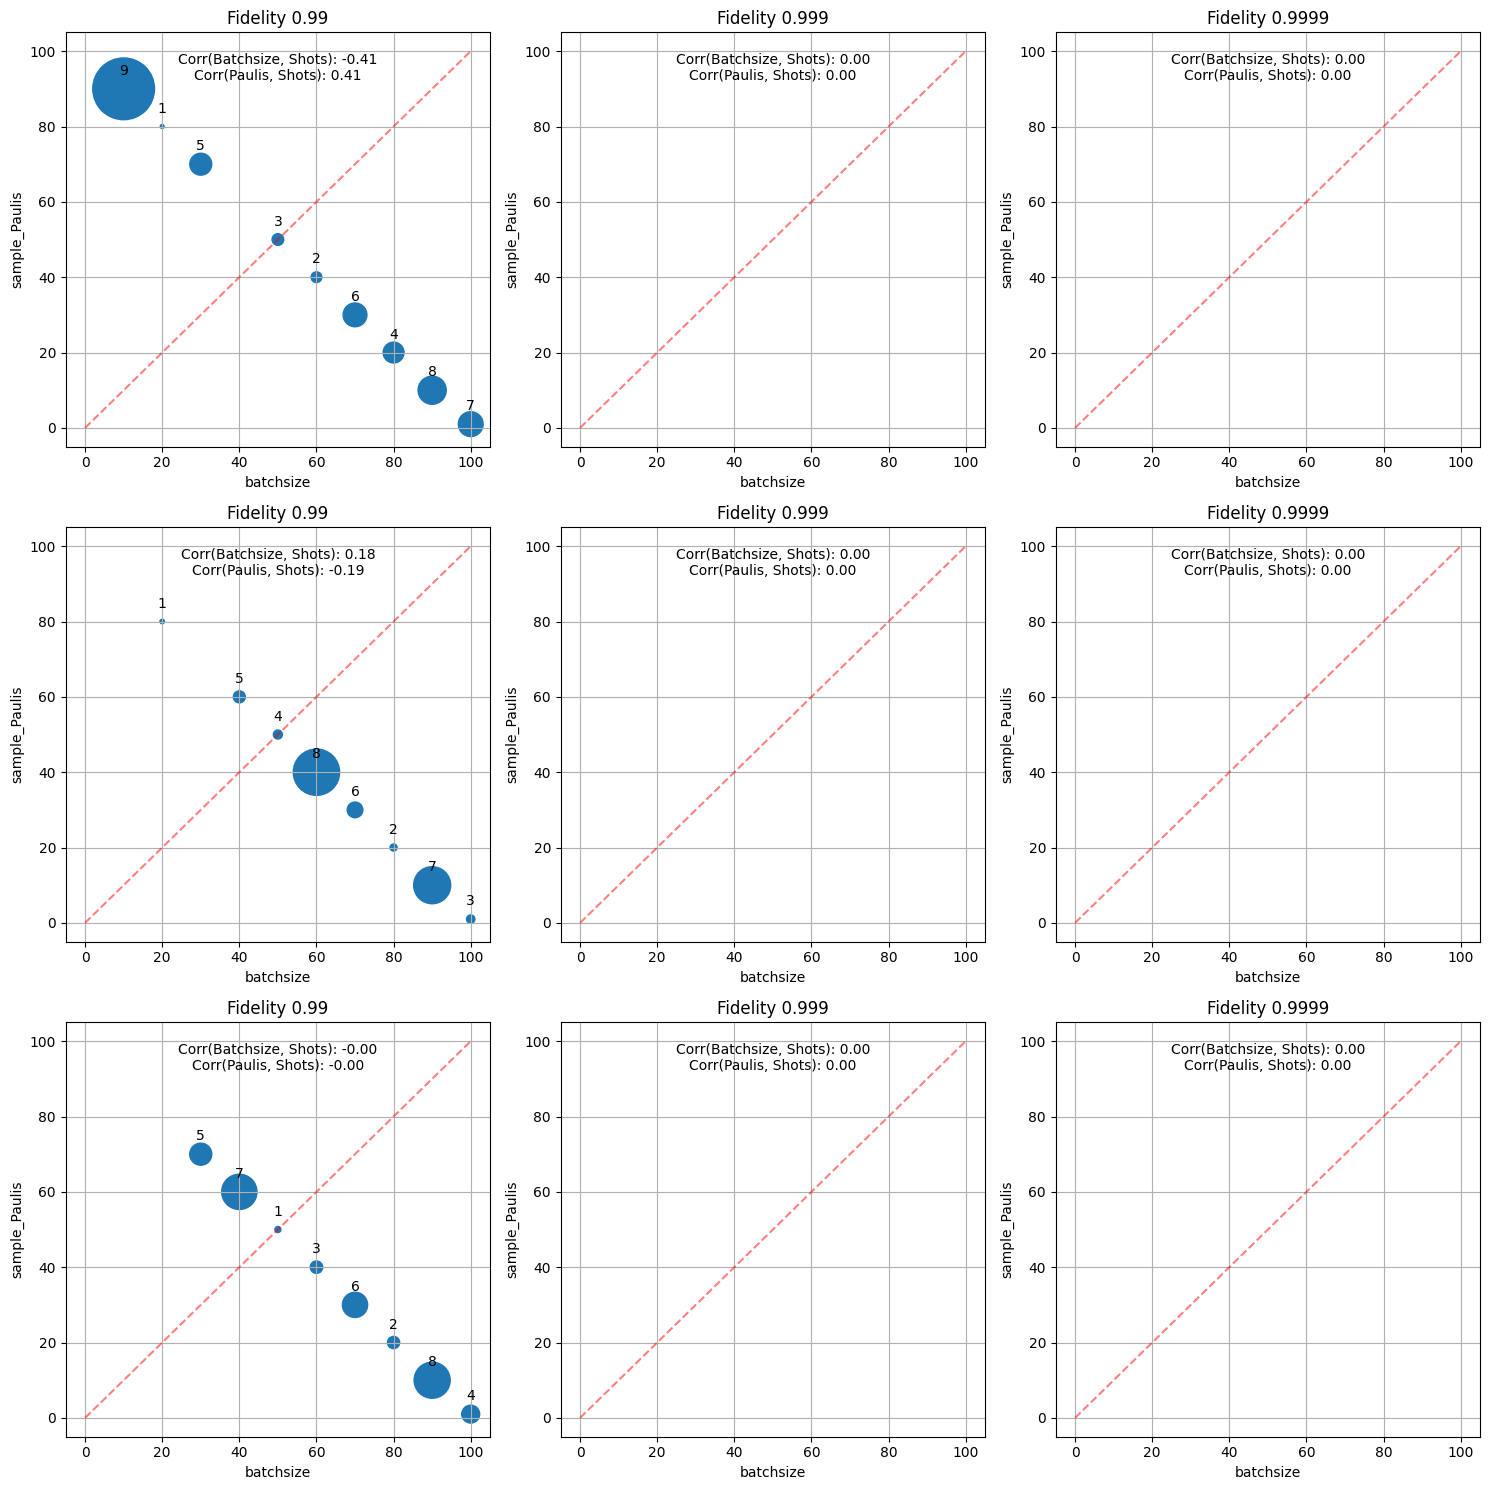

In [6]:
# Assuming multi_seed_dict is structured with 'seed' as outer keys.

# Define fidelity levels
fidelity_levels = [0.99, 0.999, 0.9999]

# Filter data once outside the plotting loop to ensure it matches the required conditions
filtered_data = {
    seed: {key: value for key, value in results.items() 
           if value['fidelity_history'] != [0]
           and value['fidelity_info'][0.99]['shots_used'] is not None}
    for seed, results in multi_seed_dict.items()
}

# Initialize subplots: one row per seed, one column per fidelity level
fig, axs = plt.subplots(len(filtered_data), len(fidelity_levels), figsize=(15, 5 * len(filtered_data)))

# Check if axs is a single dimension array when there's only one row, ensure it's always 2D
if len(filtered_data) == 1:
    axs = [axs]

# Loop over each seed and their results
for row_index, (seed, results) in enumerate(filtered_data.items()):
    # Iterate over fidelity levels and plot data
    for col_index, fidelity_level in enumerate(fidelity_levels):
        # Filter data for the current fidelity level again if needed
        current_filtered_data = {
            (x, y): data for (x, y), data in results.items()
            if data['fidelity_history'] != [0] and data['fidelity_info'][fidelity_level]['shots_used'] is not None
        }

        # Extract x, y, and sizes
        x_values = [xy[0] for xy in current_filtered_data.keys()]  # batchsize
        y_values = [xy[1] for xy in current_filtered_data.keys()]  # sample_paulis
        sizes = [data['fidelity_info'][fidelity_level]['shots_used'] for data in current_filtered_data.values()]  # num_shots

        # Calculate correlations
        if x_values and sizes:
            batchsize_numshots_corr = np.corrcoef(x_values, sizes)[0, 1]
            samplepaulis_numshots_corr = np.corrcoef(y_values, sizes)[0, 1]
        else:
            batchsize_numshots_corr, samplepaulis_numshots_corr = 0, 0  # Avoid error if empty

        # Sorting data based on sizes (number of shots used)
        sorted_data = sorted(zip(x_values, y_values, sizes), key=lambda x: x[2])

        # Unpack sorted data
        x_sorted, y_sorted, sizes_sorted = zip(*sorted_data) if sorted_data else ([], [], [])

        # Plotting for the current fidelity level
        scatter = axs[row_index][col_index].scatter(x_sorted, y_sorted, s=[size / (2.5 * 1e3) for size in sizes_sorted])
        axs[row_index][col_index].plot([0, 100], [0, 100], color='red', linestyle='--', label='Tradeoff line', alpha=0.5)

        # Annotate each point with its rank in reversed order
        for rank, (x, y, size) in enumerate(zip(x_sorted, y_sorted, sizes_sorted), start=1):
            axs[row_index][col_index].annotate(rank, (x, y), textcoords="offset points", xytext=(0, 10), ha='center', color='black')

        # Add legend and correlation info
        axs[row_index][col_index].text(0.5, 0.95, f'Corr(Batchsize, Shots): {batchsize_numshots_corr:.2f}\nCorr(Paulis, Shots): {samplepaulis_numshots_corr:.2f}',
                                        verticalalignment='top', horizontalalignment='center', transform=axs[row_index][col_index].transAxes, color='black', fontsize=10)

        axs[row_index][col_index].set_title(f'Fidelity {fidelity_level}')
        axs[row_index][col_index].set_xlabel('batchsize')
        axs[row_index][col_index].set_ylabel('sample_Paulis')
        axs[row_index][col_index].grid(True)

plt.tight_layout()
plt.show()

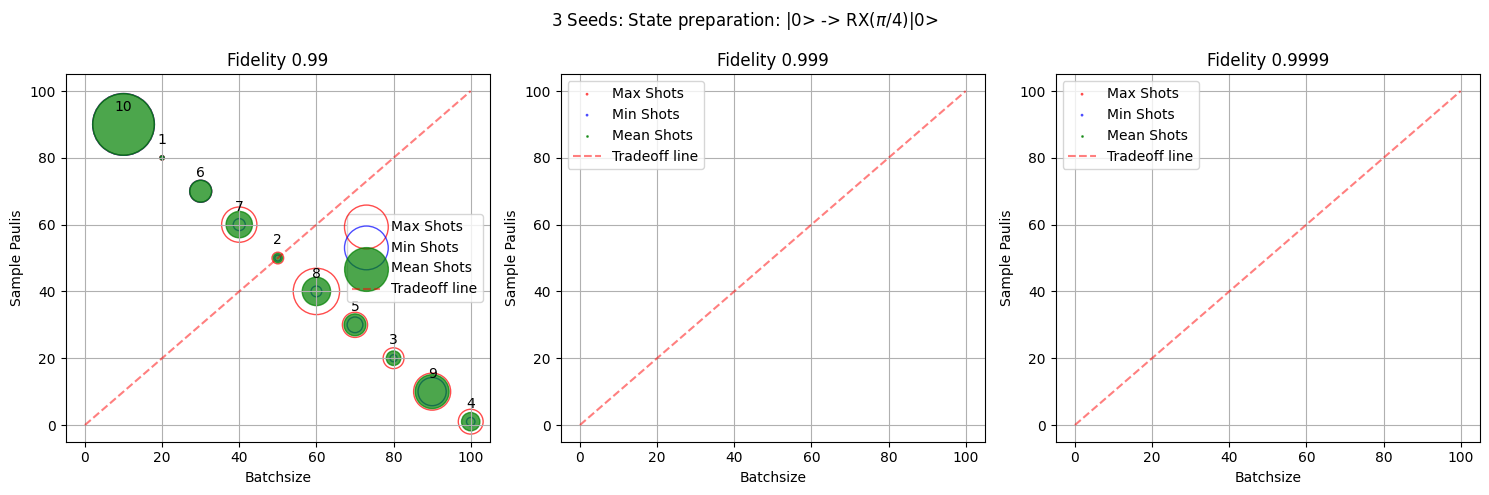

In [7]:
# Assuming `all_data` is a dictionary structured as {seed: data}

# Define fidelity levels
fidelity_levels = [0.99, 0.999, 0.9999]

# Create subplots for each fidelity level
fig, axs = plt.subplots(1, len(fidelity_levels), figsize=(15, 5))

# Iterate over fidelity levels and plot data
for i, fidelity_level in enumerate(fidelity_levels):
    # Collect data across seeds
    sizes_dict = {}

    # Iterate over seeds
    for seed, data in multi_seed_dict.items():
        for (x, y), d in data.items():
            if d['fidelity_history'] != [0] and d['fidelity_info'][fidelity_level]['shots_used'] is not None:
                if (x, y) not in sizes_dict:
                    sizes_dict[(x, y)] = []
                sizes_dict[(x, y)].append(d['fidelity_info'][fidelity_level]['shots_used'])

    # Extract x, y, and calculate mean, min, and max of sizes
    x_values = [xy[0] for xy in sizes_dict.keys()]
    y_values = [xy[1] for xy in sizes_dict.keys()]
    sizes_mean = [np.mean(sizes) for sizes in sizes_dict.values()]
    sizes_min = [np.min(sizes) for sizes in sizes_dict.values()]
    sizes_max = [np.max(sizes) for sizes in sizes_dict.values()]

    # Sorting data based on mean sizes (number of shots used) for ranking in ascending order
    sorted_data = sorted(zip(x_values, y_values, sizes_mean, sizes_min, sizes_max), key=lambda x: x[2])

    # Unpack sorted data
    x_sorted, y_sorted, sizes_mean_sorted, sizes_min_sorted, sizes_max_sorted = zip(*sorted_data) if sorted_data else ([], [], [], [], [])

    for j, (x, y, mean) in enumerate(zip(x_sorted, y_sorted, sizes_mean_sorted)):
        axs[i].annotate(f'{j+1}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center', color='black')

    # Plotting for the current fidelity level
    axs[i].scatter(x_sorted, y_sorted, s=[size_max / (2.5 * 1e3) for size_max in sizes_max_sorted], facecolors='none', edgecolors='r', alpha=0.7, label='Max Shots')
    axs[i].scatter(x_sorted, y_sorted, s=[size_min / (2.5 * 1e3) for size_min in sizes_min_sorted], facecolors='none', edgecolors='b', alpha=0.7, label='Min Shots')
    axs[i].scatter(x_sorted, y_sorted, s=[mean / (2.5 * 1e3) for mean in sizes_mean_sorted], color='g', alpha=0.7, label='Mean Shots')

    axs[i].plot([0, 100], [0, 100], color='red', linestyle='--', label='Tradeoff line', alpha=0.5)
    # Add annotations and decorations
    axs[i].set_title(f'Fidelity {fidelity_level}')
    axs[i].set_xlabel('Batchsize')
    axs[i].set_ylabel('Sample Paulis')
    axs[i].legend()
    axs[i].grid(True)

plt.suptitle('3 Seeds: State preparation: |0> -> RX($\\pi$/4)|0>')
plt.tight_layout()
plt.show()